In [293]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk, line

In [352]:
class Graph:
    """
    @args len: defines how long the Graph should be 
        Since we have 2 Inputs 5 Nodes and 1 Output we set 
        the length to 8
    """
    def __init__(self):
        self.len = 8
        
        # Defining a list containing all node objects
        self.nodes = []
    
    # Has no real use but allows for some nice representation
    def __str__(self):
        string = ""
        for i in self.nodes:
            string += str(i)
            string += "\n"

        return string

    #******************************************
    #********* Define getter and setter *******
    #******************************************

    # Returns the node given the index of the node list defined above
    def getNode(self, Id):
        return self.nodes[Id]
    
    # Is not used 
    def setParents(self):
        for node in self.nodes:
            if node.id != 1:
                checkList = [node.id for node in self.nodes]
                checkList.remove(node.id)
                parents = random.choices(checkList, k=2)

                node.conFrom = parents
    
    # helper function to print the ids of the parent nodes
    def getParents(self):
        returnStr = ""
        for node in self.nodes:
            returnStr += f"parents of Node{node.id}: {node.conFrom} \n"

        return returnStr

    #******************************************
    #*************** Graph utils **************
    #******************************************

    # gets the path of an Node
    def getPath(self, Id):
        path = []
        node = self.getNode(Id)
        parents = node.parents
        
        # Node is input (Node0 or Node1)        
        if not parents:
            return []

        # Loop over parent Nodes and get the path
        for parent in parents:
            #if parent not in path:
            path.append(parent)

            temp_parents = self.getPath(parent.Id)
            for temp_parent in temp_parents:

                #if temp_parent not in path:
                path.append(temp_parent)

        return path

    # From the nodes in the current queu select two random nodes
    def selectRandomNodes(self):
        randomNodes = random.choices(self.nodes, k=2)
        # If the selected nodes are the same call function again
        if randomNodes[0] == randomNodes[1]:
            randomNodes = self.selectRandomNodes()

        return randomNodes

    # selects random node which has not id equal to Id
    def selectSwitchNode(self, Id):
        randomNode = random.choices(self.nodes[:-1])[0]

        if randomNode.Id == Id:
            randomNode = self.selectSwitchNode(Id)
        return randomNode


    def checkCycle(self, Id):
        switchNode = self.selectSwitchNode(Id)
        path = self.getPath(switchNode.Id)

        if Id in [node.Id for node in path]:
            switchNode = self.checkCycle(Id)

        return switchNode

    def reconnectNode(self, Id):
        node = self.getNode(Id)
        parents = node.parents

        # randomly select a node from Node0 - Node6
        switchNode = self.checkCycle(Id)

        if np.random.uniform() < .5:
            node.parents[0] = switchNode
        else:
            node.parents[1] = switchNode

        # has to check if there are still unused nodes sucht that they
        # can be used to concat for the output
        unusedNodes = self.getUnusedNodes()

        if not unusedNodes:
            raise Exception('Smelly cat, smelly cat, what are they feeding you?')


    def changeOperation(self, Id):
        node = self.getNode(Id)
        operations = node.ops

        if np.random.uniform() < .5:
            operations[0] = node.randomOperation(num_operations=1)[0]
        else:
            operations[1] = node.randomOperation(num_operations=1)[0]

    
    # Used to check for changed Inputs of the ouptu Node
    def getUnusedNodes(self):
        unusedNodes = list(range(self.len-1))

        for node in self.nodes[2:-1]:
            for parent in node.parents:
                if parent.Id in unusedNodes: unusedNodes.remove(parent.Id) 

        return unusedNodes

    # for the Graph to be buildable each node has to be buildable
    # given only node0 and node1
    def isBuildable(self):
        # Debug:
        # print("testing Builability")
        # print(list(range(self.len)))
        
        buildable = False
        buildingBlocks = [0,1]

        sum_len = sum(list(range(self.len)))

        counter = 0
        while counter < 3:
            # Debug:
            # print(f"counter: {counter}")
            
            # Loops over all nodes and checks if it can be build from 
            # the given building blocks
            for node in self.nodes[2:]:

                # Since the output Node7 can have more or less than 2 Nodes
                # we simply cannot use subindexing which is why we loop 
                # over all objects contained in the parent list
                containsParents = True
                for parent in node.parents:
                    if parent.Id not in buildingBlocks:
                        containsParents = False

                if (containsParents):
                    #print(f"added {node.Id}")
                    if node.Id not in buildingBlocks: 
                        buildingBlocks.append(node.Id)
                        counter = 0

            # Order can be different and looping over list elements
            # is very expensive in python thus just take the sum 
            if sum(buildingBlocks) == sum(list(range(self.len))):
                counter = 3
                buildable = True

            # run a second check loop if the earlier elements can be build now
            counter += 1

        # DEBUG:
        # print(buildingBlocks)

        # We can use the building blocks for the tensforlow implementation
        # since the building block variable contains the flow of how
        # the nodes can be constructed
        self.buildingBlocks = buildingBlocks

        return buildable


    def drawGraph(self):
        img = np.zeros((400, 400))

        # position [y, x] 
        positions = {"0": [150,25], "1": [250,25], "7": [200, 375]}

        for i in range(2, self.len-1):
            positions[str(i)] = np.random.randint(50, 350, size=2)

        for n, pos in positions.items():
            rr, cc = disk(pos, 15)
            img[rr, cc] = (int(n)+1)/10

        
        for node in self.nodes[2:]:
            y1, x1 = positions[str(node.Id)]
            for parent in node.parents:
                y2, x2 = positions[str(parent.Id)]
                rr, cc = line(y1, x1, y2, x2)
                img[rr, cc] = (int(parent.Id)+1)/10
                

        plt.figure(figsize=(8,8))
        plt.imshow(img, cmap="jet")
        plt.show()



    #******************************************
    #************ Build Graph *****************
    #******************************************

    def buildGraph(self):
        # Initial Nodes:
        # [In0, In1]
        self.nodes.append(Node(0))
        self.nodes.append(Node(1))

        # used to concat for the output
        unusedNodes = list(range(self.len-1))

        print(f"building graph: {[node.Id for node in self.nodes]}\nunusedNodes: {unusedNodes}\n")

        # The Next Node can be selected from the initial nodes
        for index in range(2,self.len-1):
            randomNodes = self.selectRandomNodes()
            
            # adds the new combination to the node list
            self.nodes.append(Node(index, parents=randomNodes))

            # removes the nodes from the randomly selected nodes
            if randomNodes[0].Id in unusedNodes: 
                unusedNodes.remove(randomNodes[0].Id)
            if randomNodes[1].Id in unusedNodes: 
                unusedNodes.remove(randomNodes[1].Id)

            print(f"building Node{index}: {[node.Id for node in self.nodes]}\nunusedNodes: {unusedNodes}\n")
        

            
        # concat the output of the unused nodes to get the output
        self.nodes.append(Node(7, parents=[self.getNode(Id) for Id in unusedNodes]))

        print(f"building Node7: {[node.Id for node in self.nodes]}")

    

In [353]:
class Node:
    def __init__(self, NodeId, parents=None, filters=64):
        
        self.Id = NodeId
        self.parents = parents
        self.filters = filters
        self.ops = self.randomOperation()

    def __str__(self):
        return ""

    def randomOperation(self, num_operations=2):
        possible_ops = [
            tf.keras.layers.Conv2D(self.filters, 3, activation="relu"),
            tf.keras.layers.Conv2D(self.filters, 5, activation="relu"),
            tf.keras.layers.Conv2D(self.filters, 7, activation="relu"),
            tf.keras.layers.AveragePooling2D(pool_size=(3,3)),
            tf.keras.layers.MaxPool2D(pool_size=(3,3)),
            tf.keras.layers.SeparableConv2D(self.filters, (1,7), dilation_rate=3),
            tf.keras.layers.SeparableConv2D(self.filters, (7,1), dilation_rate=3)
        ]

        return random.choices(possible_ops, k=num_operations)
    

In [354]:
testGraph = Graph()
testGraph.buildGraph()
testGraph.getUnusedNodes()

building graph: [0, 1]
unusedNodes: [0, 1, 2, 3, 4, 5, 6]

building Node2: [0, 1, 2]
unusedNodes: [2, 3, 4, 5, 6]

building Node3: [0, 1, 2, 3]
unusedNodes: [2, 3, 4, 5, 6]

building Node4: [0, 1, 2, 3, 4]
unusedNodes: [2, 4, 5, 6]

building Node5: [0, 1, 2, 3, 4, 5]
unusedNodes: [2, 4, 5, 6]

building Node6: [0, 1, 2, 3, 4, 5, 6]
unusedNodes: [2, 4, 6]

building Node7: [0, 1, 2, 3, 4, 5, 6, 7]


[2, 4, 6]

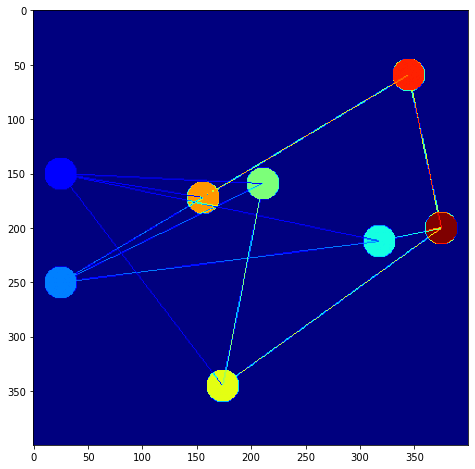

In [355]:
testGraph.drawGraph()

[2, 1, 0, 4, 3, 1, 0, 0, 6, 1, 5, 0, 1]


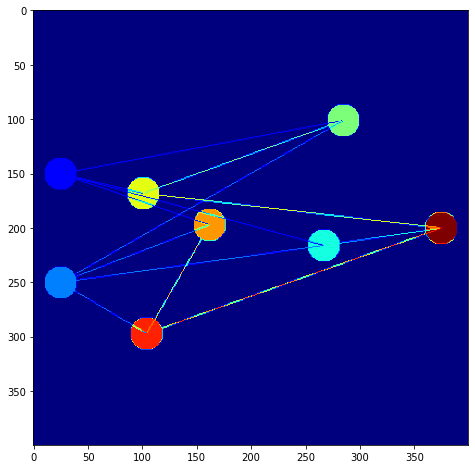

In [356]:
print([node.Id for node in testGraph.getPath(7)])
[[i.Id for i in testGraph.getPath(node.Id)] for node in testGraph.getPath(7)]
testGraph.drawGraph()
#testGraph.getUnusedNodes()
#testGraph.isBuildable()

In [357]:
errors = 0
print("start")
for i in range(10):
    NodeId = np.random.randint(2, 6)
    print(f"Node{NodeId}", end=": ")
    
    par0 = [node.Id for node in testGraph.getNode(NodeId).parents]
    print(f"Parents: {par0}", end=" || ") 
    before = [node.Id for node in testGraph.getPath(NodeId)]
    testGraph.reconnectNode(NodeId)
    print([node.Id for node in testGraph.getNode(NodeId).parents])

    print("Path before:" + str(before))
    print(f"Path after: {[node.Id for node in testGraph.getPath(NodeId)]}")
    if not testGraph.getUnusedNodes():
        errors += 1
        print("Thre is no ouptu")
    
    #testGraph.drawGraph()
    print(testGraph.isBuildable())
    print()
    if i == 100000-2:
        raise TypeError
        print("ende")

start
Node4: Parents: [3, 0] || [3, 0]
Path before:[3, 1, 0, 0]
Path after: [3, 1, 0, 0]
True

Node2: Parents: [1, 0] || [1, 0]
Path before:[1, 0]
Path after: [1, 0]
True

Node4: Parents: [3, 0] || [3, 5]
Path before:[3, 1, 0, 0]
Path after: [3, 1, 0, 5, 0, 1]
True

Node2: Parents: [1, 0] || [1, 5]
Path before:[1, 0]
Path after: [1, 5, 0, 1]
True

Node2: Parents: [1, 5] || [1, 0]
Path before:[1, 5, 0, 1]
Path after: [1, 0]
True

Node3: Parents: [1, 0] || [1, 6]
Path before:[1, 0]
Path after: [1, 6, 1, 5, 0, 1]
True

Node3: Parents: [1, 6] || [2, 6]
Path before:[1, 6, 1, 5, 0, 1]
Path after: [2, 1, 0, 6, 1, 5, 0, 1]
True

Node4: Parents: [3, 5] || [5, 5]
Path before:[3, 2, 1, 0, 6, 1, 5, 0, 1, 5, 0, 1]
Path after: [5, 0, 1, 5, 0, 1]
True

Node2: Parents: [1, 0] || [4, 0]
Path before:[1, 0]
Path after: [4, 5, 0, 1, 5, 0, 1, 0]
True

Node3: Parents: [2, 6] || [2, 6]
Path before:[2, 4, 5, 0, 1, 5, 0, 1, 0, 6, 1, 5, 0, 1]
Path after: [2, 4, 5, 0, 1, 5, 0, 1, 0, 6, 1, 5, 0, 1]
True



In [365]:
errors = 0
print("start")
for _ in range(1000000):
    NodeId = np.random.randint(2, 6)
    #print(f"Node{NodeId}", end=": ")
    
    par0 = [node.Id for node in testGraph.getNode(NodeId).parents]
    #print(f"Parents: {par0}", end=" || ") 
    #before = [node.Id for node in testGraph.getPath(NodeId)]
    testGraph.reconnectNode(NodeId)
    #print([node.Id for node in testGraph.getNode(NodeId).parents])

    #print("Path before:" + str(before))
    #print(f"Path after: {[node.Id for node in testGraph.getPath(NodeId)]}")
    if not testGraph.getUnusedNodes():
        errors += 1
        print("Thre is no ouptu")
    
    if not testGraph.isBuildable():
        raise TypeError

    if i == 100000-2:
        raise TypeError
        print("ende")

start


In [351]:
class NodeCell(tf.keras.layers.Layer):
    def __ini__(self):
        super(NodeCell, self).__ini__()

        # create the inital random Graph
        self.graph = Graph()
        self.graph.buildGraph()

    def interpreteGraph(self):
        availableNodes = [0,1]
    
        while True:
           for node in self.graph.nodes:
               # checks for 
               if 

    def call(self, inputImage):
        x = inputImage
        return x


SyntaxError: invalid syntax (<ipython-input-351-198ec3ace68f>, line 15)

In [68]:
for i in range(10):
    if i % 2 == 0:
        continue

    print(i)

1
3
5
7
9


In [98]:
[1,2,3] == [1,2,3,4]

False

In [215]:
l = {"1": [1,2,3], "2": [3,4,5]}
for key, values in l.items():
    print(i, j)

1 [1, 2, 3]
2 [3, 4, 5]


In [214]:
dir(dict)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [229]:
skimage.__version__

'0.18.1'

In [230]:
skimage.draw

AttributeError: module 'skimage' has no attribute 'draw'

In [232]:
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate


In [233]:
ellipse

<function skimage.draw.draw.ellipse(r, c, r_radius, c_radius, shape=None, rotation=0.0)>

In [280]:
print(list(range(2,8)))

[2, 3, 4, 5, 6, 7]
